# Transformer Network
## After this assignment you'll be able to:

- Create positional encodings to capture sequential relationships in data
- Calculate scaled dot-product self-attention with word embeddings
- Implement masked multi-head attention
- Build and train a Transformer model

In [1]:
import sys
import tensorflow as tf
import keras
import transformers
import numpy as np
import matplotlib

print(f"Python version       : {sys.version}")
print(f"TensorFlow version   : {tf.__version__}")
print(f"Keras version        : {keras.__version__}")
print(f"Transformers version : {transformers.__version__}")
print(f"NumPy version        : {np.__version__}")
print(f"Matplotlib version   : {matplotlib.__version__}")

Python version       : 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:26:18) [MSC v.1929 64 bit (AMD64)]
TensorFlow version   : 2.12.0
Keras version        : 2.12.0
Transformers version : 4.30.0
NumPy version        : 1.23.5
Matplotlib version   : 3.9.4


In [2]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification

# 1 - Positional Encoding
In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model. However, when you train a Transformer network using multi-head attention, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:

$$PE_{(pos, 2i)} = sin(\frac{pos}{10000^{\frac {2i}{d}}}) \tag 1$$
$$PE_{(pos, 2i+1)} = cos(\frac{pos}{10000^{\frac {2i}{d}}}) \tag 2$$

 - __d__ is the dimension of the word embedding and positional encoding
 - __pos__ is the position of the word.
 - __k__ refers to each of the different dimensions in the positional encodings, with __i__ equal to __k // 2.__

To develop some intuition about positional encodings, you can think of them broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model. If you just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the semantic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. This was a short discussion on positional encodings, but to develop further intuition, check out the Positional Encoding Ungraded Lab.

Note: In the lectures Andrew uses vertical vectors, but in this assignment all vectors are horizontal. All matrix multiplications should be adjusted accordingly.

# 1.1 - Sine and Cosine Angles
Notice that even though the sine and cosine positional encoding equations take in different arguments (2i versus 2i+1, or even versus odd numbers) the inner terms for both equations are the same:

$$\theta (pos,i,d) = \frac {pos}{10000^\frac{2i}{d}} \tag 3$$

Consider the inner term as you calculate the positional encoding for a word in a sequence.

$PE_{(pos, 0)} = sin(\frac{pos}{10000^{\frac {0}{d}}})$, since solving 2i = 0 gives i = 0

$PE_{(pos, 1)} = cos(\frac{pos}{10000^{\frac {0}{d}}})$, since solving 2i + 1 = 1 gives i = 0

The angle is the same for both! The angles for $PE_{(pos,2)}$ and $PE_{(pos,3)}$ are the same as well, since for both, i = 1 and therefore the inner term is $(\frac{pos}{10000^{\frac{2}{d}}})$. This relationship holds true for all paired sine and cosine curves:

| k             | 0                 | 1                 | 2                 | 3      | ...   | d-2               | d-1               |
|---------------|------------------|------------------|------------------|--------|-------|------------------|------------------|
| encoding(0) = | $\sin(\theta(0,0,d))$ | $\cos(\theta(0,0,d))$ | $\sin(\theta(0,1,d))$ |$\cos(\theta(0,1,d))$| ...   | $\sin(\theta(0,\frac{d}{2},d))$ | $\cos(\theta(0,\frac{d}{2},d))$ |
| encoding(1) = | $\sin(\theta(1,0,d))$ | $\cos(\theta(1,0,d))$ | $\sin(\theta(1,1,d))$ |$\cos(\theta(1,1,d))$| ...   | $\sin(\theta(1,\frac{d}{2},d))$ | $\cos(\theta(1,\frac{d}{2},d))$ |
| encoding(pos) = | $\sin(\theta(pos,0,d))$ | $\cos(\theta(pos,0,d))$ | $\sin(\theta(pos,1,d))$ |$\cos(\theta(pos,1,d))$| ...   | $\sin(\theta(pos,\frac{d}{2},d))$ | $\cos(\theta(pos,\frac{d}{2},d))$ |

# Exercise 1 - get_angles
Implement the function get_angles() to calculate the possible angles for the sine and cosine positional encodings

## Hints

- If k = [0, 1, 2, 3, 4, 5], then, i must be i = [0, 0, 1, 1, 2, 2]

- i = k//2


In [3]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION get_angles
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # START CODE HERE
    # Get i from dimension span k
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos / 10000**(2*i/d)
    # END CODE HERE
    
    return angles

In [4]:
from public_tests import *

get_angles_test(get_angles)

# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

All tests passed


array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

# Exercise 2 - positional_encoding
Implement the function positional_encoding() to calculate the sine and cosine positional encodings

Reminder: Use the sine equation when __i__ is an even number and the cosine equation when __i__ is an odd number.

In [5]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [6]:
# UNIT TEST    
positional_encoding_test(positional_encoding, get_angles)

All tests passed


(1, 50, 512)


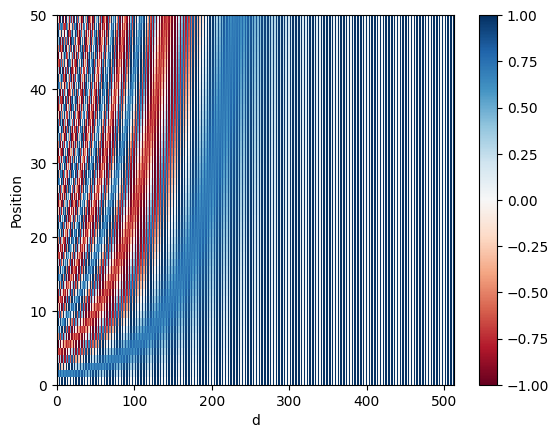

In [7]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 2 - Masking
There are two types of masks that are useful when building your Transformer network: the padding mask and the look-ahead mask. Both help the softmax computation give the appropriate weights to the words in your input sentence.


# 2.1 - Padding Mask
Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

[["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
 ["Jane", "visits", "Africa", "in", "September" ],
 ["Exciting", "!"]
]
which might get vectorized as:

[[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
 [ 56, 1285, 15, 181, 545],
 [ 87, 600]
]
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

[[ 71, 121, 4, 56, 99],
 [ 2344, 345, 1284, 15, 0],
 [ 56, 1285, 15, 181, 545],
 [ 87, 600, 0, 0, 0],
]
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! You will need to define a boolean mask that specifies to which elements you must attend(1) and which elements you must ignore(0). Later you will use that mask to set all the zeros in the sequence to a value close to negative infinity (-1e9). We'll implement this for you so you can get to the fun of building the Transformer network! 😇 Just make sure you go through the code so you can correctly implement padding when building your model.

After masking, your input should go from [87, 600, 0, 0, 0] to [87, 600, -1e9, -1e9, -1e9], so that when you take the softmax, the zeros don't affect the score.

The MultiheadAttention layer implemented in Keras, uses this masking logic.

Note: The below function only creates the mask of an already padded sequence. Later in this week, you’ll go through some Labs on Transformer applications, where you’ll be introduced to TensorFlow Tokenizer and Hugging Face Tokenizer, which internally handle padding (and truncating) the input sequence.

In [8]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :]  

In [9]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


If we multiply (1 - mask) by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity. Notice the difference when taking the softmax of the original sequence and the masked sequence:

In [10]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876638e-01 2.6809818e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952457e-01 6.2391245e-01 3.1062772e-02 3.1062772e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088354e-03]
  [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00 9.0030573e-02]
  [6.6483542e-03 6.6483542e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057157e-01 2.6876226e-01 6.6619506e-04 0.0000000e+00 0.0000000e+00]
  [9.0030566e-02 2.4472845e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00]
  [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01 5.0000000e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]]], shape=(3, 3, 5), dtype=float32)


# 2.2 - Look-ahead Mask
The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.

For example, if the expected correct output is [1, 2, 3] and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence [1, -1e9, -1e9] and see if it could generate [1, 2, -1e9].

Just because you've worked so hard, we'll also implement this mask for you 😇😇. Again, take a close look at the code so you can effectively implement it later.

In [11]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [12]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

# 3 - Self-Attention
As the authors of the Transformers paper state, "Attention is All You Need".
![Attension](images/attension.png)

Figure 1: Self-Attention calculation visualization

The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. You will implement scaled dot product attention which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:

$$Attention(Q,K,V) = Softmax(\frac {QK^T}{\sqrt{d_k}} + M ) V \tag {4}$$

 - Q is the matrix of queries
 - K is the matrix of keys
 - V is the matrix of values
 - M is the optional mask you choose to apply
 - d_k is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

# Exercise 3 - scaled_dot_product_attention
Implement the function scaled_dot_product_attention() to create attention-based representations.

Reminder: The boolean mask parameter can be passed in as none or as either padding or look-ahead.

Multiply (1. - mask) by -1e9 before applying the softmax. 

Additional Hints

You may find tf.matmul useful for matrix multiplication.

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
#     # START CODE HERE
    
#     matmul_qk = None  # (..., seq_len_q, seq_len_k)

#     # scale matmul_qk
#     dk = None
#     scaled_attention_logits = None

#     # add the mask to the scaled tensor.
#     if mask is not None: # Don't replace this None
#         scaled_attention_logits += None 

#     # softmax is normalized on the last axis (seq_len_k) so that the scores
#     # add up to 1.
#     attention_weights = None  # (..., seq_len_q, seq_len_k)

#     output = None  # (..., seq_len_q, depth_v)
    
#     # END CODE HERE
    
    # START CODE HERE
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None: # Don't replace this None
        scaled_attention_logits += ((1. - mask) * -1e9) 

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    # END CODE HERE    

    return output, attention_weights

In [14]:
# UNIT TEST
scaled_dot_product_attention_test(scaled_dot_product_attention)

All tests passed


# 4 - Encoder
The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a).

![Encoder](images/encoder.png)

- MultiHeadAttention you can think of as computing the self-attention several times to detect different features.
- Feed forward neural network contains two Dense layers which we'll implement as the function FullyConnected

Your input sentence first passes through a multi-head attention layer, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a feed forward neural network. The exact same feed forward network is independently applied to each position.

- For the MultiHeadAttention layer, you will use the Keras implementation. If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation.
- You will also use the Sequential API with two dense layers to built the feed forward neural network layers.

In [15]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, embedding_dim)
    ])

# 4.1 Encoder Layer
Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).


# Exercise 4 - EncoderLayer
Implement EncoderLayer() using the call() method

In this exercise, you will implement one encoder block (Figure 2) using the call() method. The function should perform the following steps:

1. You will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute self-attention Q, V and K should be the same. Set the default values for return_attention_scores and training. You will also perform Dropout in this multi-head attention layer during training.
2. Now add a skip connection by adding your original input x and the output of the your multi-head attention layer.
3. After adding the skip connection, pass the output through the first normalization layer.
4. Finally, repeat steps 1-3 but with the feed forward neural network with a dropout layer instead of the multi-head attention layer.
## Additional Hints (Click to expand)
- The __init__ method creates all the layers that will be accesed by the the call method. Wherever you want to use a layer defined inside the __init__ method you will have to use the syntax self.[insert layer name].
- You will find the documentation of MultiHeadAttention helpful. Note that if query, key and value are the same, then this function performs self-attention.
- The call arguments for self.mha are (Where B is for batch_size, T is for target sequence shapes, and S is output_shape):
- query: Query Tensor of shape (B, T, dim).
- value: Value Tensor of shape (B, S, dim).
- key: Optional key Tensor of shape (B, S, dim). If not given, will use value for both key and value, which is the most common case.
- attention_mask: a boolean mask of shape (B, T, S), that prevents attention to certain positions. The boolean mask specifies which query elements can attend to which key elements, 1 indicates attention and 0 indicates no attention. Broadcasting can happen for the missing batch dimensions and the head dimension.
- return_attention_scores: A boolean to indicate whether the output should be attention output if True, or (attention_output, attention_scores) if False. Defaults to False.
- training: Python boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (no dropout). Defaults to either using the training mode of the parent layer/model, or False (inference) if there is no parent layer. Take a look at tf.keras.layers.Dropout for more details (Additional reading in Keras FAQ)

In [16]:
# GRADED FUNCTION EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output during training (~1 line)
        # use `training=training` 
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        # END CODE HERE
        
        return encoder_layer_out

In [ ]:
# UNIT TEST
EncoderLayer_test(EncoderLayer)

# 4.2 - Full Encoder
Awesome job! You have now successfully implemented positional encoding, self-attention, and an encoder layer - give yourself a pat on the back. Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embed your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers.



![Full encoder](images/fullEncoder.png)

# Exercise 5 - Encoder
Complete the Encoder() function using the call() method to embed your input, add positional encoding, and implement multiple encoder layers.

In this exercise, you will initialize your Encoder with an Embedding layer, positional encoding, and multiple EncoderLayers. Your call() method will perform the following steps:

1. Pass your input through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type tf.float32 before computing the square root.
3. Add the position encoding: self.pos_encoding [:, :seq_len, :] to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the training parameter to set the model training mode.
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [20]:
# GRADED FUNCTION
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
        
        # START CODE HERE
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, embedding_dim)

In [21]:
# UNIT TEST    
Encoder_test(Encoder)

AssertionError: Wrong values case 1

# 5 - Decoder
The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

![Decoder](images/decoder.png)

# 5.1 - Decoder Layer
Again, you'll pair multi-head attention with a feed forward neural network, but this time you'll implement two multi-head attention layers. You will also use residual connections and layer normalization to help speed up training (Figure 3a).
# Exercise 6 - DecoderLayer
Implement DecoderLayer() using the call() method

1. Block 1 is a multi-head attention layer with a residual connection, and look-ahead mask. Like in the EncoderLayer, Dropout is defined within the multi-head attention layer.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a normalization layer and a residual connection, just like you did before with the EncoderLayer.
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.
## Additional Hints:

The first two blocks are fairly similar to the EncoderLayer except you will return attention_scores when computing self-attention

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x + mult_attn_out1)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line) 
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
                
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(mult_attn_out2 + ffn_output)  # (batch_size, target_seq_len, embedding_dim)
        # END CODE HERE

        return out3, attn_weights_block1, attn_weights_block2

In [19]:
# UNIT TEST
DecoderLayer_test(DecoderLayer, create_look_ahead_mask)

AssertionError: Wrong values in attn_w_b1. Check the call to self.mha1

![Full Decoder](images/fullDecoder.png)

# Exercise 7 - Decoder
Implement Decoder() using the call() method to embed your output, add positional encoding, and implement multiple decoder layers.

In this exercise, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your call() method will perform the following steps:

1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type tf.float32 before computing the square root.
3. Add the position encoding: self.pos_encoding [:, :seq_len, :] to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the training parameter to set the model training mode.
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [34]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # START CODE HERE
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [ ]:
# UNIT TEST
Decoder_test(Decoder, create_look_ahead_mask, create_padding_mask)

# 6 - Transformer
Phew! This has been quite the assignment, and now you've made it to your last exercise of the Deep Learning Specialization. Congratulations! You've done all the hard work, now it's time to put it all together.

![Transformer](images/transformer.png)

The flow of data through the Transformer Architecture is as follows:

- First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
- Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
- Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.

# Exercise 8 - Transformer
Implement Transformer() using the call() method

1. Pass the input through the Encoder with the appropiate mask.
2. Pass the encoder output and the target through the Decoder with the appropiate mask.
3. Apply a linear transformation and a softmax to get a prediction.

In [36]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
                              An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
                              An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # START CODE HERE
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)  # (batch_size, inp_seq_len, embedding_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
        # END CODE HERE

        return final_output, attention_weights

In [ ]:
# UNIT TEST
Transformer_test(Transformer, create_look_ahead_mask, create_padding_mask)

# Conclusion
You've come to the end of the graded portion of the assignment. By now, you've:

- Created positional encodings to capture sequential relationships in data
- Calculated scaled dot-product self-attention with word embeddings
- Implemented masked multi-head attention
- Built and trained a Transformer model
## What you should remember:
- The combination of self-attention and convolutional network layers allows of parallelization of training and faster training.
- Self-attention is calculated using the generated query Q, key K, and value V matrices.
- Adding positional encoding to word embeddings is an effective way to include sequence information in self-attention calculations.
- Multi-head attention can help detect multiple features in your sentence.
- Masking stops the model from 'looking ahead' during training, or weighting zeroes too much when processing cropped sentences.